# Naive Bayes Classifier From Scratch
In this experiment, the Naive Bayes method will be implemented from scratch using PyTorch.<br>
We will train our model on the [Student Alcohol Consumption](https://www.kaggle.com/uciml/student-alcohol-consumption) dataset to try to predict if a student frequently drink alcohol or not.

The data contains the following attributes:
- school - student's school (binary: 'GP' - Gabriel Pereira or 'MS' - Mousinho da Silveira)
- sex - student's sex (binary: 'F' - female or 'M' - male)
- age - student's age (numeric: from 15 to 22)
- address - student's home address type (binary: 'U' - urban or 'R' - rural)
- famsize - family size (binary: 'LE3' - less or equal to 3 or 'GT3' - greater than 3)
- Pstatus - parent's cohabitation status (binary: 'T' - living together or 'A' - apart)
- Medu - mother's education (numeric: 0 - none, 1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
- Fedu - father's education (numeric: 0 - none, 1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
- Mjob - mother's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')
- Fjob - father's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')
- reason - reason to choose this school (nominal: close to 'home', school 'reputation', 'course' preference or 'other')
- guardian - student's guardian (nominal: 'mother', 'father' or 'other')
- traveltime - home to school travel time (numeric: 1 - 1 hour)
- studytime - weekly study time (numeric: 1 - 10 hours)
- failures - number of past class failures (numeric: n if 1<=n<3, else 4)
- schoolsup - extra educational support (binary: yes or no)
- famsup - family educational support (binary: yes or no)
- paid - extra paid classes within the course subject (Math or Portuguese) (binary: yes or no)
- activities - extra-curricular activities (binary: yes or no)
- nursery - attended nursery school (binary: yes or no)
- higher - wants to take higher education (binary: yes or no)
- internet - Internet access at home (binary: yes or no)
- romantic - with a romantic relationship (binary: yes or no)
- famrel - quality of family relationships (numeric: from 1 - very bad to 5 - excellent)
- freetime - free time after school (numeric: from 1 - very low to 5 - very high)
- goout - going out with friends (numeric: from 1 - very low to 5 - very high)
- health - current health status (numeric: from 1 - very bad to 5 - very good)
- absences - number of school absences (numeric: from 0 to 93)
- G1 - first period grade (numeric: from 0 to 20)
- G2 - second period grade (numeric: from 0 to 20)
- G3 - final grade (numeric: from 0 to 20, output target)
- Dalc - workday alcohol consumption (numeric: from 1 - very low to 5 - very high)
- Walc - weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)

In [155]:
import os
import math
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.base import BaseEstimator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

### Read csv with Pandas

In [144]:
students_mat = pd.read_csv(os.path.join('data', 'student-mat.csv'))
students_por = pd.read_csv(os.path.join('data', 'student-por.csv'))

In [145]:
# Concatenating students data from math and portuguese class
students = pd.concat([students_mat, students_por], axis=0)

In [146]:
# Averaging three grades into one single grade
students['grade'] = (students['G1'] + students['G1'] + students['G3']) / 3

# Combining weekly and weekend alcohol consumption into a single attribute
students['alc'] = students['Walc'] + students['Dalc']

# Drop the combined columns
students = students.drop(columns=['G1', 'G2', 'G3', 'school'])

In [147]:
students.head(3)

,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,...,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,grade,alc
0,F,18,U,GT3,A,4,4,at_home,teacher,course,...,no,4,3,4,1,1,3,6,5.333333,2
1,F,17,U,GT3,T,1,1,at_home,other,course,...,no,5,3,3,1,1,3,4,5.333333,2
2,F,15,U,LE3,T,1,1,at_home,other,other,...,no,4,3,2,2,3,3,10,8.000000,5


### Transform string to categorical values

In [148]:
categorical_dict = {}
for col in students.columns:
    # For each column of type object, use sklearn label encoder and add the mapping to a dictionary
    if students[col].dtype == 'object':
        le = LabelEncoder() 
        students[col] = le.fit_transform(students[col])
        categorical_dict[col] = dict(zip(le.classes_, le.transform(le.classes_)))

In [149]:
pprint(categorical_dict)

{'Fjob': {'at_home': 0, 'health': 1, 'other': 2, 'services': 3, 'teacher': 4},
 'Mjob': {'at_home': 0, 'health': 1, 'other': 2, 'services': 3, 'teacher': 4},
 'Pstatus': {'A': 0, 'T': 1},
 'activities': {'no': 0, 'yes': 1},
 'address': {'R': 0, 'U': 1},
 'famsize': {'GT3': 0, 'LE3': 1},
 'famsup': {'no': 0, 'yes': 1},
 'guardian': {'father': 0, 'mother': 1, 'other': 2},
 'higher': {'no': 0, 'yes': 1},
 'internet': {'no': 0, 'yes': 1},
 'nursery': {'no': 0, 'yes': 1},
 'paid': {'no': 0, 'yes': 1},
 'reason': {'course': 0, 'home': 1, 'other': 2, 'reputation': 3},
 'romantic': {'no': 0, 'yes': 1},
 'schoolsup': {'no': 0, 'yes': 1},
 'sex': {'F': 0, 'M': 1}}


Here is the dictonary of the categorical labels

### Correlation heatmap

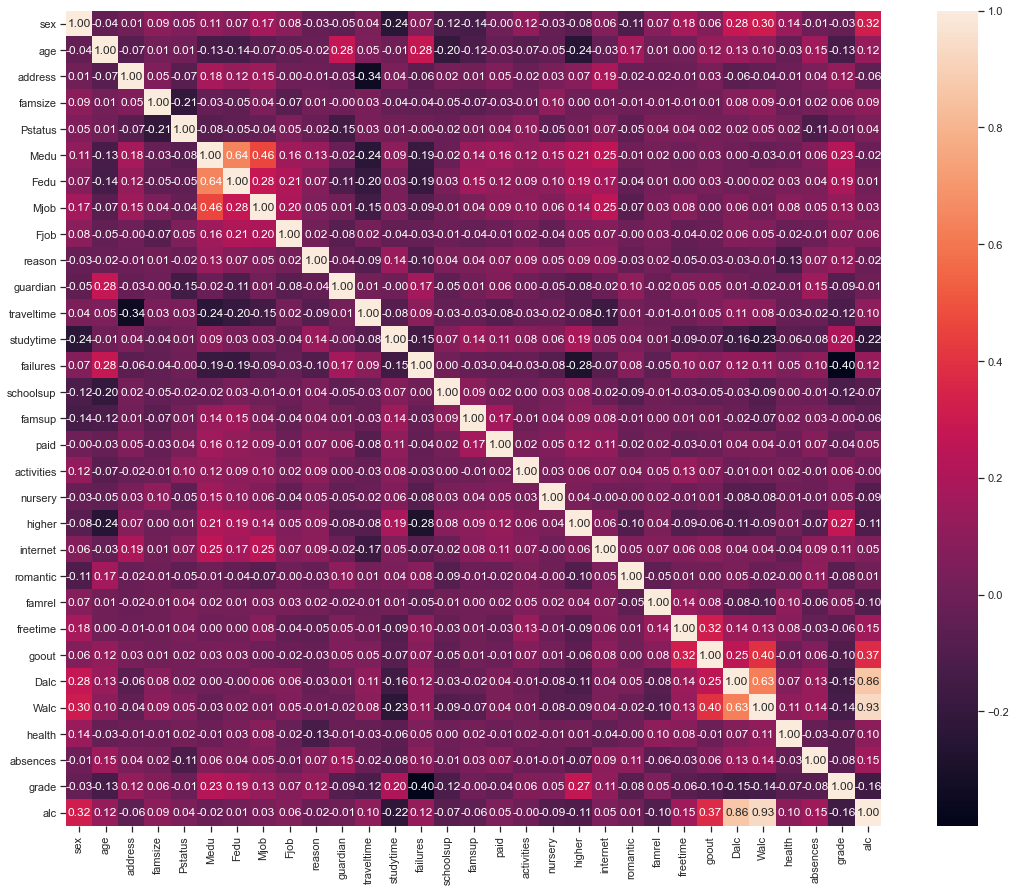

In [150]:
plt.figure(figsize=(20, 15))
sns.heatmap(students.corr(), annot=True, square=True, fmt='0.2f')

Just from the correlation heatmap, we can have an overview of the impact of alcohol consumption on students.
Based on the linear correlation between the target and the features, students consuming alcohol frequently have more chance to:
- have lower grades
- have more absences
- hang out more often
- does not aim to achieve higher education
- study less

Among all theses cases, the attributes that are the most correlated with the target are the grades, the study time and if the student is a men.

### Impact of alcohol consumption on students life

In [177]:
def plot_pie(data, column, ax):
    counts = data[column].value_counts()
    percent = counts / counts.sum() * 100
    labels = alc_workday.index
    ax.pie(x=percent, labels=labels, autopct='%1.0f%%')

Text(0.5, 1.0, 'Weekdend Alcohol Consumption')

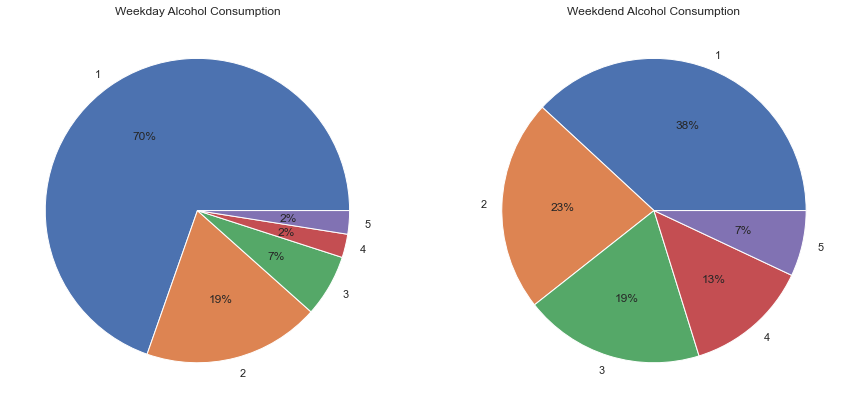

In [180]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
plot_pie(students, column='Dalc', ax=ax1)
plot_pie(students, column='Walc', ax=ax2)
ax1.set_title('Weekday Alcohol Consumption')
ax2.set_title('Weekend Alcohol Consumption')

The alcohol consumption during workdays is relatively low compared to the weekend consumption.<br>
Let's see how those behaviors have an impact on students success and life.

In [160]:
alc_workday

1    398
2    235
3    200
4    138
5     73
Name: Walc, dtype: int64

In [157]:
percent

1    0.381226
2    0.225096
3    0.191571
4    0.132184
5    0.069923
Name: Walc, dtype: float64

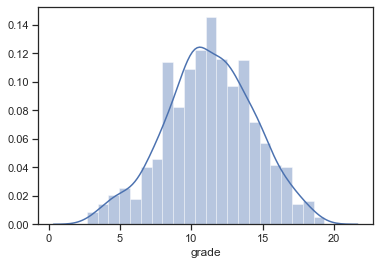

In [143]:
sns.distplot(students['grade'])

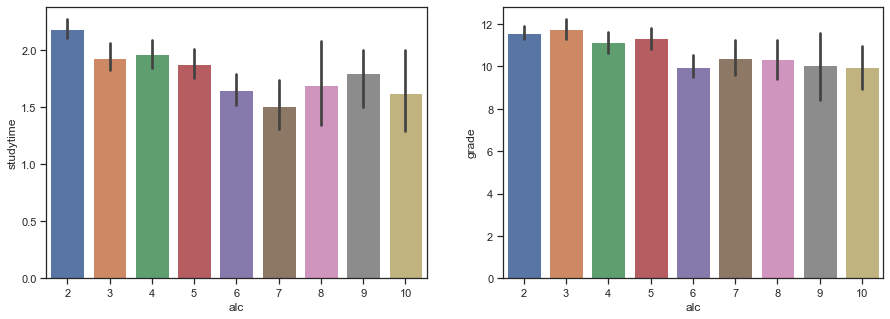

In [133]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.barplot(x='alc', y='studytime', data=students, ax=axes[0])
sns.barplot(x='alc', y='grade', data=students, ax=axes[1])

### Converting alcohol consumption to a categorical label
The original label goes from 1 to 5 from no consumption to severe consumption.<br>
Weekly and weekend consumption does not seem relevent for alcohol consumption prediction so we combined the two attributes by summing them.<br>
In other words, the combine attribute can be seen as the weekly alcohol consumption.<br>

The fourth values seems like a good threshold to create two categorical classes:
- $[2, 4]$ the student does not or drink in moderation
- $[5, 10]$ the student does drink frequently.

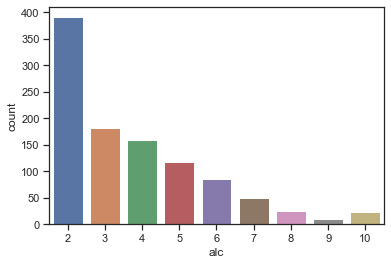

In [134]:
sns.coplot(students['alc'])

In [103]:
students.loc[students['alc'] <= 4, 'alc'] = 0
students.loc[students['alc'] > 4, 'alc'] = 1


In [76]:
numeric_cols = ['age',
                'traveltime',
                'studytime',
                'failures',
                'famrel',
                'freetime',
                'goout',
                'health',
                'absences',
                'grade',
                'alc']

In [77]:
is_categorical = []
for col in students.columns:
    if col in numeric_cols:
        is_categorical.append(0)
    else:
        is_categorical.append(1)

In [78]:
X = torch.from_numpy(students.iloc[:, :-1].values).float()
y = torch.from_numpy(students.iloc[:, -1].values).float()

In [79]:
class NaiveBayesClassifier(BaseEstimator):
    def __init__(self, offset=1):
        self.offset = offset
        pass
    
    def fit(self, X, y, **kwargs):
        if 'is_categorical' not in kwargs:
            raise ValueError('must pass \'is_categorical\' to fit through **kwargs')
        self.is_categorical = kwargs['is_categorical']
        size = X.shape[0]
        
        self.nb_features = X.shape[1]
        y_uvals = y.unique()
        self.nb_class = len(y_uvals)
        self.class_probs = y.int().bincount().float() / size
        
        features_maxvals = torch.zeros((self.nb_features,), dtype=torch.int32)
        for j in range(self.nb_features):
            features_maxvals[j] = X[:, j].max()
        
        cond_probs = [] 
        for i in range(self.nb_class):
            cond_probs.append([])
            idx = torch.where(y == y_uvals[i])[0]
            elts = X[idx]
            
            size_class = elts.shape[0]
            for j in range(self.nb_features):
                cond_probs[i].append([])
                if self.is_categorical[j]:
                    for k in range(features_maxvals[j] + 1):
                        p_x_k = (torch.where(elts[:, j] == k)[0].shape[0] + self.offset) / size_class
                        cond_probs[i][j].append(p_x_k)
                else:
                    features_class = elts[:, j]
                    mean = features_class.mean()
                    std = (features_class - mean).pow(2).mean().sqrt()
                    cond_probs[i][j] = [mean, std]
        self.cond_probs = cond_probs
        return 0
    
    def gaussian_likelihood(self, X, mean, std):
        return (1 / (2 * math.pi * std.pow(2))) * torch.exp(-0.5 * ((X - mean) / std).pow(2))
    
    def predict(self, X):
        if len(X.shape) == 1:
            X = X.unsqueeze(0)
        
        nb_samples = X.shape[0]
        pred_probs = torch.zeros((nb_samples, self.nb_class), dtype=torch.float32)
        for k in range(nb_samples):
            elt = X[k]
            for i in range(self.nb_class):
                pred_probs[k][i] = self.class_probs[i]
                prob_feature_per_class = self.cond_probs[i]
                for j in range(self.nb_features):
                    if self.is_categorical[j]:
                        pred_probs[k][i] *= prob_feature_per_class[j][elt[j].int()]
                    else:
                        mean, std = prob_feature_per_class[j]
                        pred_probs[k][i] *= self.gaussian_likelihood(elt[j], mean, std)
        return pred_probs.argmax(dim=1)

In [80]:
nbc = NaiveBayesClassifier()

fit_params = {'is_categorical' : is_categorical}
cross_val_score(nbc, X, y, cv=5, scoring='accuracy', fit_params=fit_params).mean()

0.7422846889952153